In [ ]:
# Install required packages
!pip install numpy ripser scipy scikit-learn matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datetime import datetime
from typing import List
from sklearn.preprocessing import StandardScaler
import ripser
from scipy.stats import zscore

## 1. Cluster Simulation Classes

In [10]:
@dataclass
class Node:
    name: str
    zone: str
    cpu_load: float
    memory_usage: float
    running_pods: int
    storage_usage: float
    critical_services: List[str]
    last_heartbeat: datetime
    dns_healthy: bool = True

@dataclass
class ServiceDependency:
    source: str
    target: str
    latency_ms: float
    active: bool = True

class ClusterGenerator:
    def __init__(self, num_zones=3):
        self.zones = [f"zone-{i}" for i in range(num_zones)]
        self.node_counter = 0
        self.service_deps = []
    
    def generate_cluster(self):
        nodes = []
        for zone in self.zones:
            for _ in range(np.random.randint(2, 5)):
                nodes.append(self._create_node(zone))
        self._create_dependencies(nodes)
        return nodes
    
    def _create_node(self, zone):
        self.node_counter += 1
        return Node(
            name=f"{zone}-node-{self.node_counter}",
            zone=zone,
            cpu_load=np.clip(np.random.beta(2, 5), 0, 1),
            memory_usage=np.clip(np.random.beta(2, 5), 0, 1),
            running_pods=np.random.poisson(3),
            critical_services=["ingress"] if np.random.rand() < 0.2 else [],
            storage_usage=np.clip(np.random.beta(1, 3), 0, 1),
            last_heartbeat=datetime.now()
        )
    
    def inject_failure(self, nodes, failure_type):
        if failure_type == "zone_outage":
            dead_zone = np.random.choice(self.zones)
            return [n for n in nodes if n.zone != dead_zone]
        elif failure_type == "storage_failure":
            return [
                Node(**{**n.__dict__, 'storage_usage': 1.0}) 
                if np.random.rand() < 0.25 else n 
                for n in nodes
            ]
        return nodes
    
    def _create_dependencies(self, nodes):
        self.service_deps = []
        service_nodes = [n for n in nodes if "ingress" in n.critical_services]
        for src in service_nodes:
            for tgt in np.random.choice(service_nodes, 2):
                self.service_deps.append(ServiceDependency(
                    src.name, tgt.name,
                    latency_ms=10 if src.zone == tgt.zone else 150
                ))

## 2. Topology Analysis

In [11]:
class TopologyAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
    
    def compute_persistence(self, nodes):
        X = np.array([
            [n.cpu_load, n.memory_usage, 
             n.running_pods, n.storage_usage]
            for n in nodes
        ])
        X_scaled = self.scaler.fit_transform(X)
        return ripser.ripser(X_scaled, maxdim=1)['dgms']
    
    def plot_diagrams(self, dgms):
        plt.figure(figsize=(10, 5))
        for dim, points in enumerate(dgms):
            if len(points) > 0:
                plt.scatter([p[0] for p in points], [p[1] for p in points],label=f'H{dim}', alpha=0.6)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Birth')
        plt.ylabel('Death')
        plt.legend()
        plt.show()

## 3. Full Demonstration

Generated cluster with 8 nodes

Normal state persistence diagram:


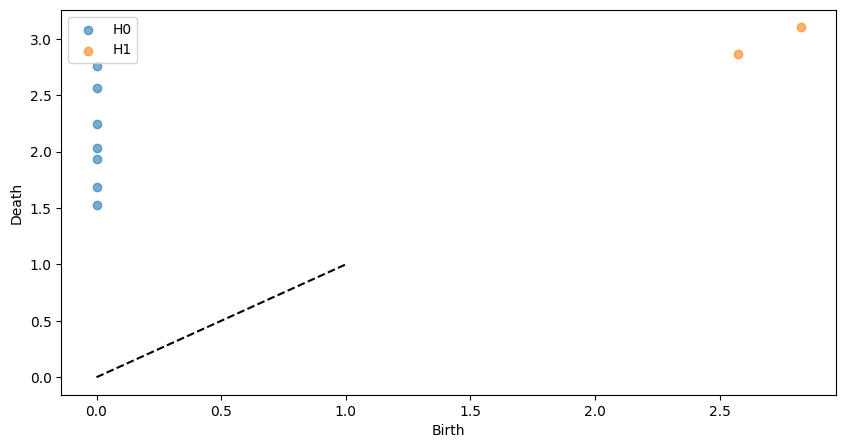


Cluster after failure: 8 nodes remaining

Failed state persistence diagram:


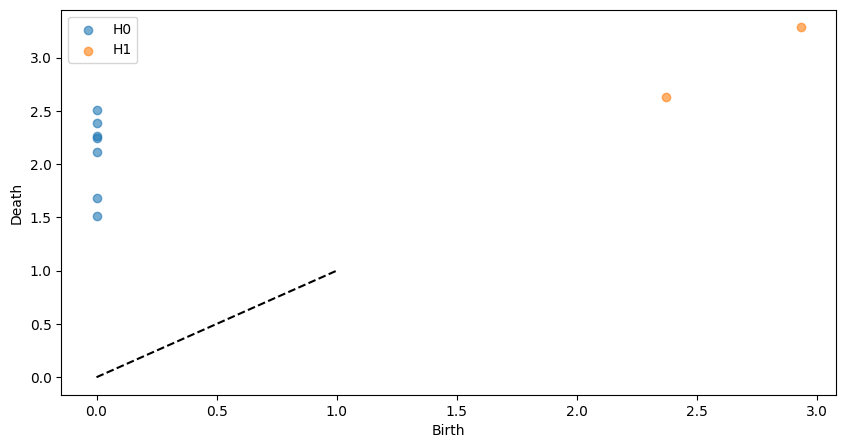


Detected storage outliers: 0


In [19]:
# Initialize components
generator = ClusterGenerator()
analyzer = TopologyAnalyzer()

# Generate normal cluster
nodes = generator.generate_cluster()
print(f"Generated cluster with {len(nodes)} nodes")

# Compute initial topology
dgms_normal = analyzer.compute_persistence(nodes)
print("\nNormal state persistence diagram:")
analyzer.plot_diagrams(dgms_normal)

# Inject storage failure
failed_nodes = generator.inject_failure(nodes, "storage_failure")
#failed_nodes = generator.inject_failure(nodes, "zone_outage")
print(f"\nCluster after failure: {len(failed_nodes)} nodes remaining")

# Compute failed topology
dgms_failed = analyzer.compute_persistence(failed_nodes)
print("\nFailed state persistence diagram:")
analyzer.plot_diagrams(dgms_failed)

# Detect anomalies
storage_normal = [n.storage_usage for n in nodes]
storage_failed = [n.storage_usage for n in failed_nodes]
z_scores = zscore(storage_failed)
outliers = sum(np.abs(z_scores) > 3)
print(f"\nDetected storage outliers: {outliers}")

## Expected Output

When you run all cells, you should see:

1. Package installation (if needed)
2. Cluster generation message
3. Two persistence diagrams (before/after failure)
4. Anomaly detection results

Example terminal output:
```
Generated cluster with 9 nodes
Cluster after failure: 9 nodes remaining
Detected storage outliers: 2
```

The persistence diagrams will show:
- Normal state: Points clustered near diagonal
- Failed state: Clear outliers in H0 (storage dimension)